In [1]:
import collections
import itertools
import os
import sys
import textwrap
import warnings
from functools import partial, reduce
from importlib import reload
from itertools import chain
from operator import itemgetter
from pathlib import Path
from pprint import pprint

import clip
import matplotlib.pyplot
import matplotlib.pyplot as plt
import medmnist
import numpy as np
import pandas as pd
import torch

sys.path.append("../src")
import clip
import valuation
from opendataval.dataloader import DataFetcher
from opendataval.dataval import (
    DataOob,
    DataShapley,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)
from opendataval.model import ClassifierSkLearnWrapper, RegressionSkLearnWrapper
from PIL import Image
from scipy.stats import kendalltau, pearsonr
from sklearn import random_projection
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    DistanceMetric,
    accuracy_score,
    adjusted_mutual_info_score,
    f1_score,
    v_measure_score,
)
from sklearn.metrics.cluster import homogeneity_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from torchvision.transforms import Compose, ToPILImage
from tqdm.notebook import tqdm
from vendi_score import vendi

plt.rcParams["font.family"] = "serif"
fig_dir = Path("figures")
from collections import defaultdict

warnings.filterwarnings("ignore", category=ConvergenceWarning)
reload(valuation)

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


<module 'valuation' from '/u/luchar/data-valuation/nbs/../src/valuation.py'>

In [2]:
saved_embedding_path = Path("../embeddings")

In [3]:
datasets = {
    "mnist": torch.load(saved_embedding_path / "clip_embedding_MNIST.pt"),
    "fashion": torch.load(saved_embedding_path / "clip_embedding_Fashion.pt"),
    "emnist": torch.load(saved_embedding_path / "clip_embedding_EMNIST.pt"),
    "stl10": torch.load(saved_embedding_path / "clip_embedding_STL10.pt"),
    "svhn": torch.load(saved_embedding_path / "clip_embedding_SVHN.pt"),
    "cifar": torch.load(saved_embedding_path / "clip_embedding_CIFAR10.pt"),
    "imagenet-val": torch.load(
        saved_embedding_path / "clip_embedding_imagenet_original.pt"
    ),
    "imagenet-s": torch.load(saved_embedding_path / "clip_embedding_imagenet_s.pt"),
    "imagenet-r": torch.load(saved_embedding_path / "clip_embedding_imagenet_r.pt"),
    "imagenet-a": torch.load(saved_embedding_path / "clip_embedding_imagenet_a.pt"),
    "imagenet-v2": torch.load(saved_embedding_path / "clip_embedding_imagenet_v2.pt"),
    "blood": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_bloodmnist_224.pt"
    ),
    "breast": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_breastmnist_224.pt"
    ),
    "chest": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_chestmnist_224.pt"
    ),
    "derma": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_dermamnist_224.pt"
    ),
    "path": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_pathmnist_224.pt"
    ),
    "pneumonia": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_pneumoniamnist_224.pt"
    ),
    "retina": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_retinamnist_224.pt"
    ),
    "tissue": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_tissuemnist_224.pt"
    ),
    "organ": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_organamnist_224.pt"
    ),
}

In [7]:
for k, v in datasets.items():
    print(k, len(v["embeddings"]))

mnist 60000
fashion 60000
emnist 697932
stl10 5000
svhn 73257
cifar 50000
imagenet-val 50000
imagenet-s 50889
imagenet-r 30000
imagenet-a 7500
imagenet-v2 10000
blood 11959
breast 546
chest 78468
derma 7007
path 89996
pneumonia 4708
retina 1080
tissue 165466
organ 34561


In [4]:
figures_dir = Path("../new-figures")

In [5]:
measures = [
    "l2",
    "cosine",
    "correlation",
    "overlap",
    "volume",
    "vendi",
    "dispersion",
    "difference",
]

In [6]:
n_components = 10

### Ranking

In [8]:
def rank(d: dict, buyer):
    sorted_values = sorted([(k, v) for k, v in d.items()], key=lambda x: x[1])[::-1]
    ranking = zip(itertools.count(start=1), [x[0] for x in sorted_values])
    for r, v in ranking:
        if v == buyer:
            return r

In [10]:
num_buy = 100
num_sell = 10000
num_trials = 10

rank_results = defaultdict(list)
for j in range(num_trials):
    for buyer in tqdm(datasets.keys()):
        results = defaultdict(list)
        B = datasets[buyer]["embeddings"]
        for seller, v in datasets.items():
            S = datasets[seller]["embeddings"]
            _, buy = train_test_split(B, test_size=num_buy, random_state=j)
            _, sell = train_test_split(
                S, test_size=min(len(S) - 1, num_sell), random_state=j
            )
            results[seller] = valuation.get_measurements(buy, sell)

        for m in measures:
            rank_results[m].append(
                rank(dict(zip(results.keys(), [v[m] for v in results.values()])), buyer)
            )

  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
for k, v in rank_results.items():
    print()
    print(k, np.mean(v).round(2), end="\t")
    print(np.std(v).round(2))
    print(k, np.mean(1 / np.log2(1 + np.array(v))).round(2), end="\t")
    print(np.std(1 / np.log2(1 + np.array(v))).round(2))


l2 1.15	0.36
l2 0.94	0.13

cosine 1.15	0.48
cosine 0.96	0.13

correlation 1.25	0.7
correlation 0.93	0.16

overlap 1.2	0.6
overlap 0.95	0.15

volume 3.6	5.36
volume 0.81	0.3

vendi 3.7	2.45
vendi 0.58	0.26

dispersion 2.75	2.75
dispersion 0.78	0.29

difference 19.65	0.79
difference 0.23	0.0


In [12]:
buyer = "imagenet-val"
buy = datasets[buyer]["embeddings"][:100]
meas = {}
for k, v in datasets.items():
    sell = v["embeddings"][100:10100]
    meas[k] = valuation.get_measurements(buy, sell)

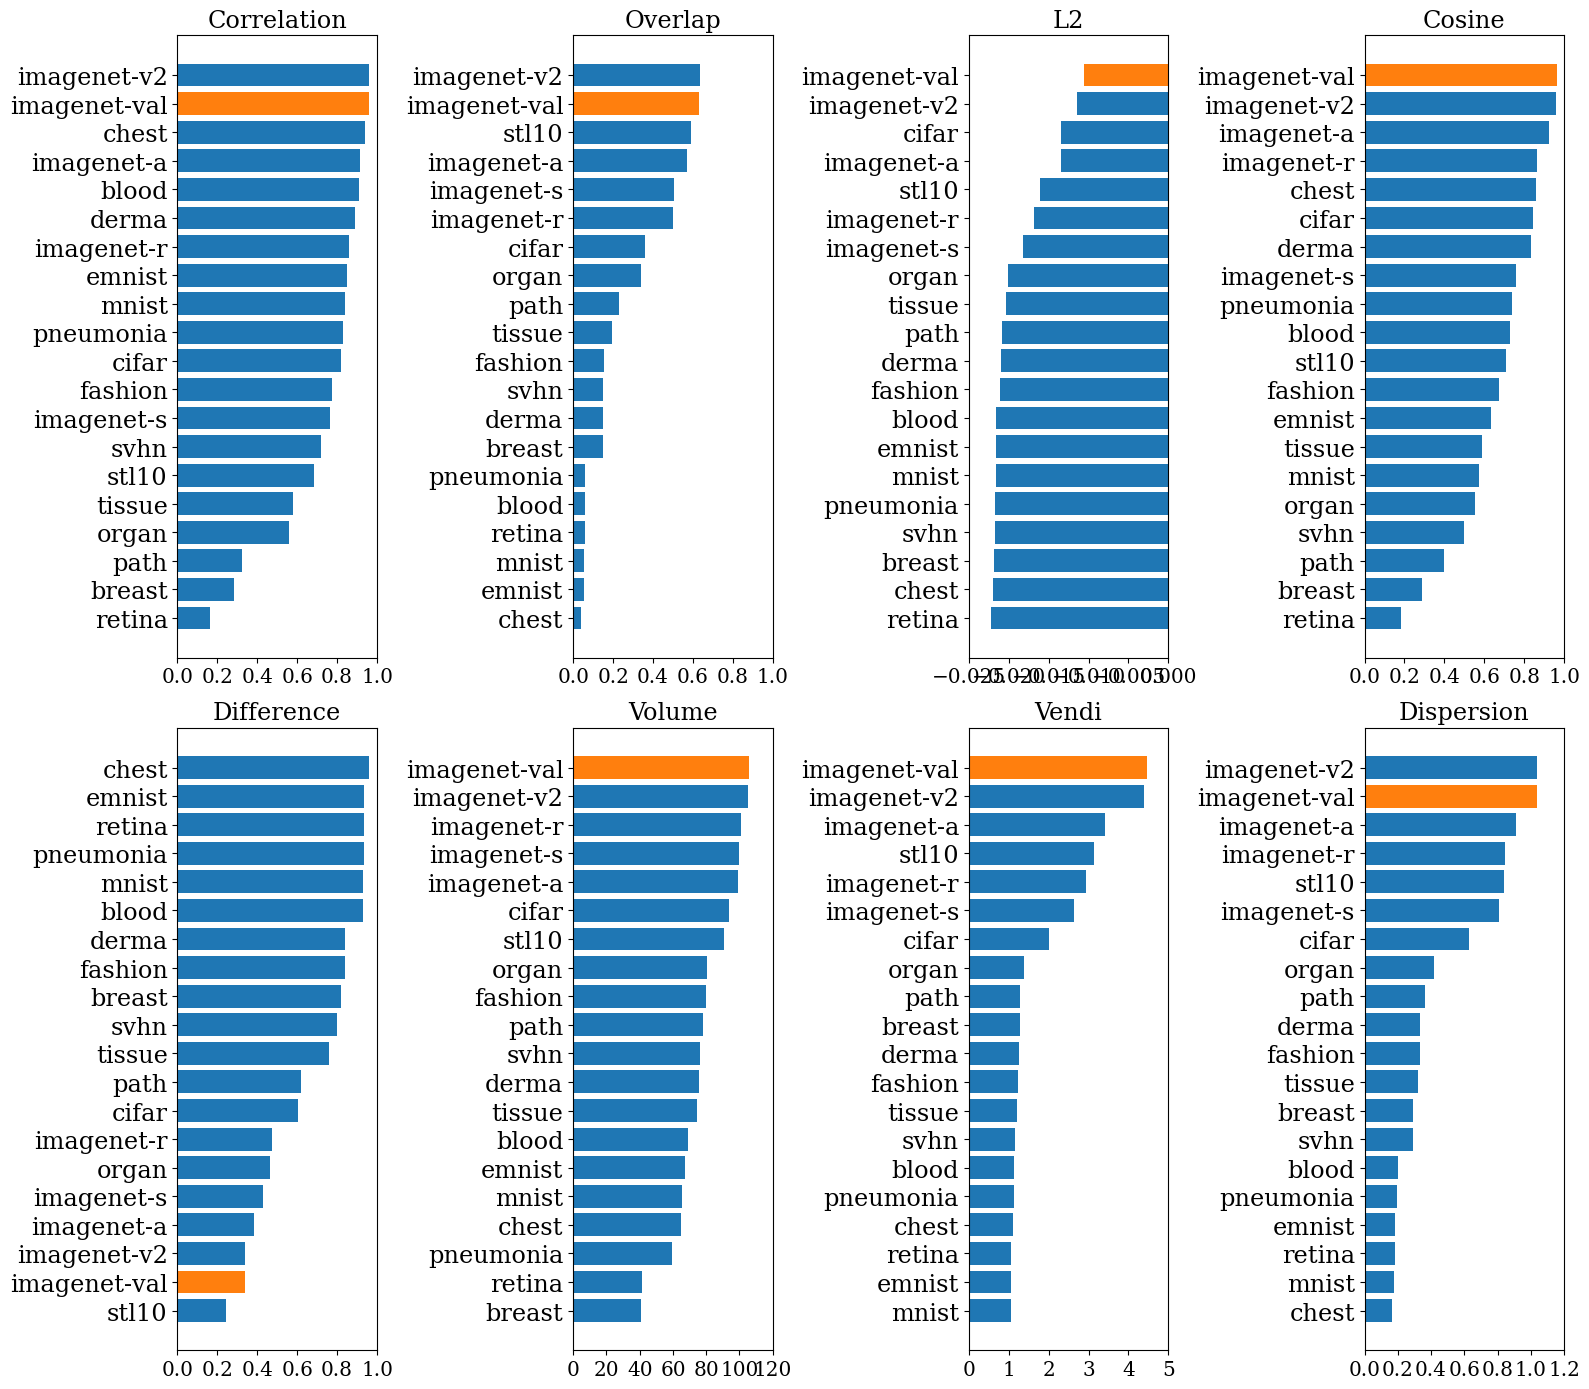

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(16, 14))

for ax, val in zip(axes.flat, meas["mnist"].keys()):
    names = list(meas.keys())
    values = [v[val] for v in meas.values()]
    index = np.argsort(values)
    sorted_names = [names[i] for i in index]
    sorted_values = [values[i] for i in index]
    color = ["C1" if names[i] == buyer else "C0" for i in index]

    if val in ["correlation", "overlap", "difference", "cosine"]:
        ax.set_xlim(0, 1)

    ax.barh(
        sorted_names,
        sorted_values,
        color=color,
    )
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), fontsize="x-large")
    ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize="xx-large")
    ax.set_title(val.capitalize(), fontsize="xx-large")
fig.tight_layout(w_pad=0)
# plt.savefig(figures_dir / f"ranking.eps", bbox_inches="tight", dpi=800)

### Varying amount of seller/buyer data

In [14]:
num_trials = 10
num_buy = 100
exclude = ["breast", "retina"]


range_seller_samples = [
    10,
    50,
    100,
    500,
    1000,
    5000,
    10000,
    25000,
    50000,
]

size_results = defaultdict(list)
for buyer in tqdm(datasets.keys()):
    if buyer in exclude:
        continue
    results = defaultdict(list)
    X = datasets[buyer]["embeddings"]
    for j in range(num_trials):
        for num_sell in range_seller_samples:
            sell, buy = train_test_split(
                X,
                train_size=min(len(X) - num_buy, num_sell),
                test_size=num_buy,
                random_state=j,
            )
            results[num_sell].append(valuation.get_measurements(buy, sell))
    size_results[buyer] = results

  0%|          | 0/20 [00:00<?, ?it/s]

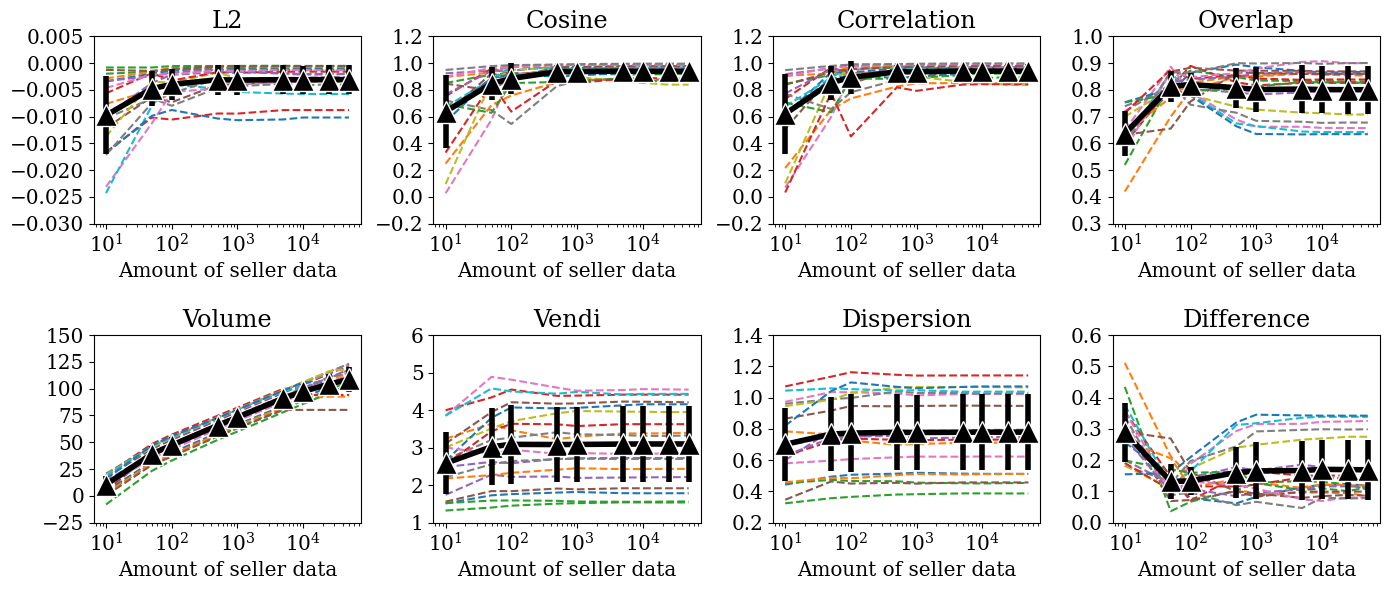

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))

for ax, val in zip(axes.flat, measures):
    agg = []
    # agg_std  = []
    for k, v in size_results.items():
        values = [np.mean(list(map(itemgetter(val), meas))) for meas in v.values()]
        ax.plot(v.keys(), values, ls="--", marker="")
        agg.append(values)
    ax.errorbar(
        range_seller_samples,
        np.mean(agg, 0),
        yerr=np.std(agg, 0),
        lw=4,
        ls="-",
        marker="^",
        markersize=16,
        markeredgecolor="w",
        c="k",
    )
    # ax.set_xticks(range(8), ['0', '2', '4', '8', '16', '32', '64', '128'], fontsize='x-large')
    ax.set_xlabel("Amount of seller data", fontsize="x-large")
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), fontsize="x-large")
    ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize="x-large")
    ax.set_title(val.capitalize(), fontsize="xx-large")
    ax.set_xscale("log")

fig.tight_layout(w_pad=1, h_pad=2)

# plt.savefig(figures_dir / f"seller-compare.eps", bbox_inches="tight")

In [16]:
num_trials = 10
num_sell = 5000
range_buyer_samples = [
    10,
    50,
    100,
    500,
    1000,
    5000,
    10000,
    # 15000,
]
exclude = [
    "breast",
    "blood",
    "retina",
    "stl10",
    "pneumonia",
    "derma",
    "imagenet-a",
    "imagenet-v2",
]

buyer_results = defaultdict(list)
for buyer in tqdm(datasets.keys()):
    if buyer in exclude:
        continue
    results = defaultdict(list)
    X = datasets[buyer]["embeddings"]
    # print(buyer, len(X), len(X) - 10000)
    for j in range(num_trials):
        for num_buy in range_buyer_samples:
            sell, buy = train_test_split(
                X,
                train_size=min(len(X) - num_buy, num_sell),
                test_size=num_buy,
                random_state=j,
            )
            results[num_buy].append(valuation.get_measurements(buy, sell))
    buyer_results[buyer] = results

  0%|          | 0/20 [00:00<?, ?it/s]

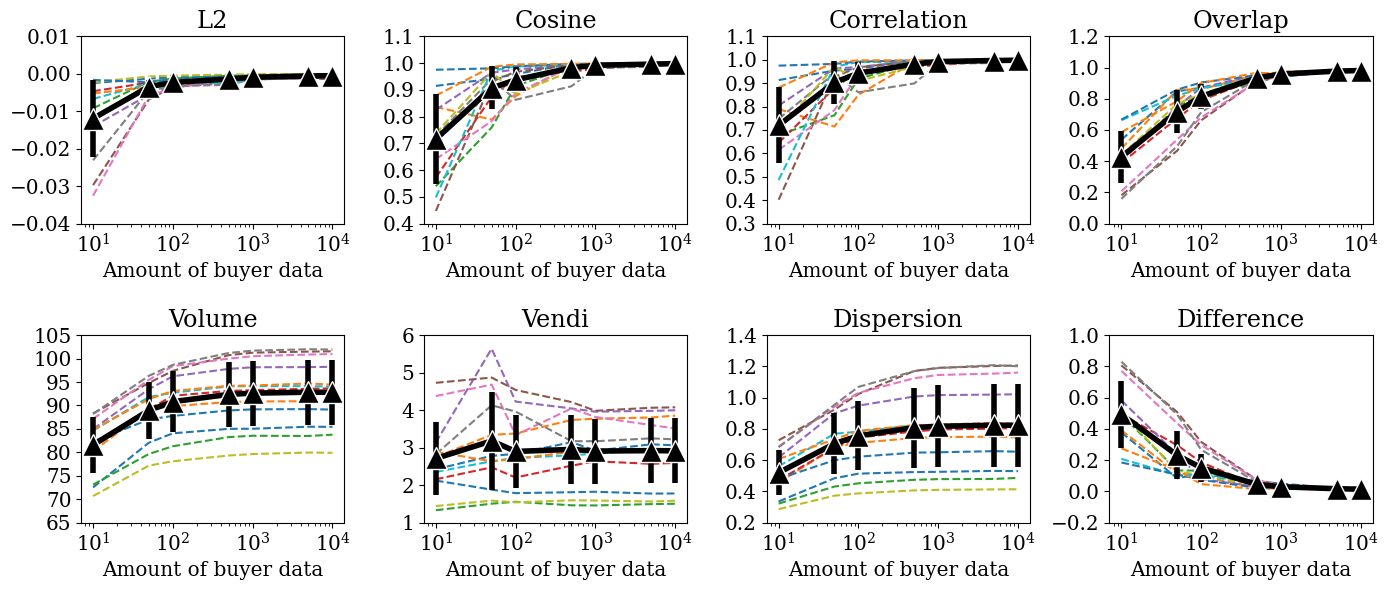

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))

for ax, val in zip(axes.flat, measures):
    agg = []
    # agg_std  = []
    for k, v in buyer_results.items():
        values = [np.mean(list(map(itemgetter(val), meas))) for meas in v.values()]
        ax.plot(v.keys(), values, ls="--", marker="")
        agg.append(values)
    ax.errorbar(
        range_buyer_samples,
        np.mean(agg, 0),
        yerr=np.std(agg, 0),
        lw=4,
        ls="-",
        marker="^",
        markersize=16,
        markeredgecolor="w",
        c="k",
    )
    # ax.set_xticks(range(8), ['0', '2', '4', '8', '16', '32', '64', '128'], fontbuyer='x-large')
    ax.set_xlabel("Amount of buyer data", fontsize="x-large")
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), fontsize="x-large")
    ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize="x-large")
    ax.set_title(val.capitalize(), fontsize="xx-large")
    ax.set_xscale("log")

fig.tight_layout(w_pad=1, h_pad=2)

# plt.savefig(figures_dir / f"buyer-compare.eps", bbox_inches="tight")

### False projections

In [18]:
buyer = "imagenet-val"
buy = datasets[buyer]["embeddings"][:100]
meas = {}
for k, v in datasets.items():
    sell = v["embeddings"][100:1000]
    meas[k] = valuation.get_measurements(buy, sell)

In [19]:
# real = 'imagenet-val'
# real = 'blood'
# buyers = ['blood', 'fashion', 'path', real]

all_results = {}
all_ratios = {}
for seller in tqdm(datasets.keys()):
    sell = datasets[seller]["embeddings"][100:1100]
    results = {}
    for buyer in tqdm(datasets.keys()):
        buy = datasets[buyer]["embeddings"][:100]
        # results[buyer] = valuation.get_measurements(buy, sell, decomp=FastICA)
        results[buyer] = valuation.get_measurements(buy, sell)

    ratio = {}
    for val in results["mnist"].keys():
        values = [v[val] for v in results.values()]
        index = np.argsort(values)
        sorted_names = [names[i] for i in index]
        sorted_values = [values[i] for i in index]
        all_results[seller] = results
        pos = results[seller][val]
        neg_mean = np.mean([results[s][val] for s in datasets.keys() if s != seller])
        ratio[val] = (pos - min(sorted_values)) / (neg_mean - min(sorted_values))
    all_ratios[seller] = ratio

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

2.1266646394877213
2.360867758856869
1.1105535334120775
1.992971403660385
0.07583966302722756
1.5433859208064697
1.5937638205399103
2.543524544167981


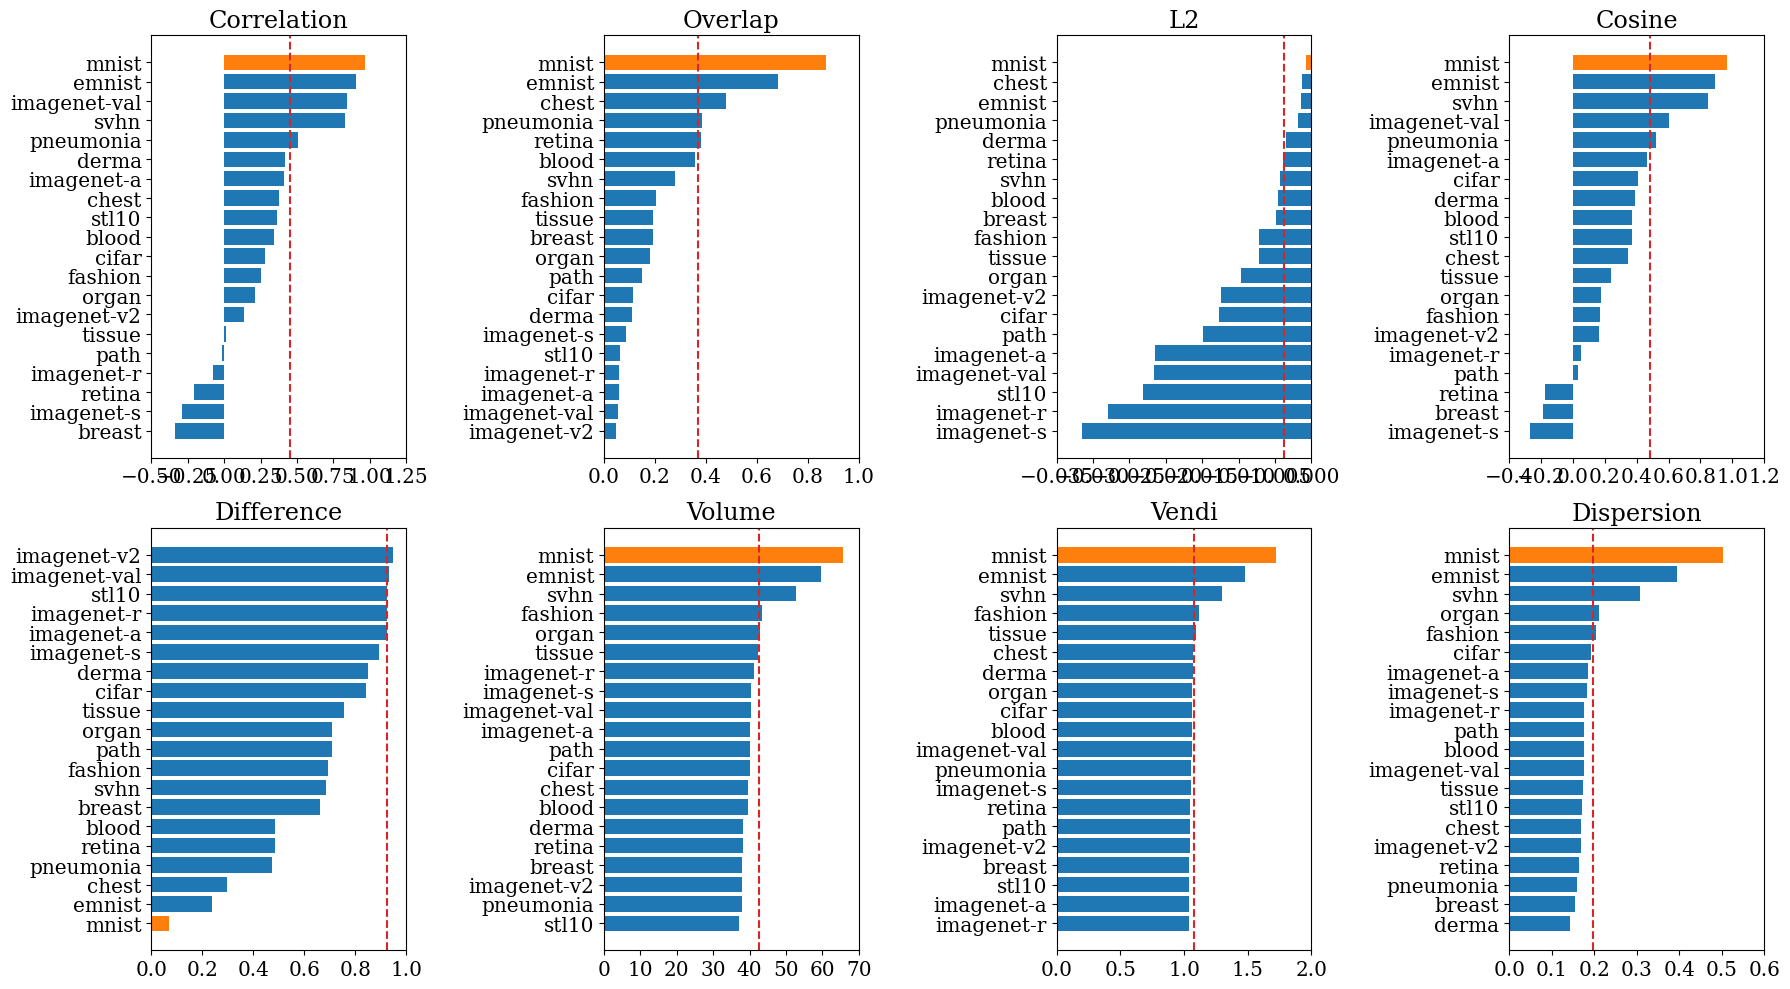

In [20]:
real = "mnist"
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

for ax, val in zip(axes.flat, all_results[real]["mnist"].keys()):
    names = list(all_results[real].keys())
    values = [v[val] for v in all_results[real].values()]
    index = np.argsort(values)
    sorted_names = [names[i] for i in index]
    sorted_values = [values[i] for i in index]
    color = ["C1" if names[i] == real else "C0" for i in index]

    pos = [b for a, b in zip(sorted_names, sorted_values) if a == real][0]
    # neg_mean = np.mean([b for a, b in zip(sorted_names, sorted_values) if a != real ])
    # neg_mean = np.median([b for a, b in zip(sorted_names, sorted_values) if a != real ])
    neg_mean = np.quantile(
        [b for a, b in zip(sorted_names, sorted_values) if a != real], 0.8
    )
    ax.axvline(neg_mean, ls="--", c="C3", label="Mean")
    if val == "l2":
        print((pos - min(sorted_values)) / (neg_mean - min(sorted_values)))
    else:
        print(pos / neg_mean)
    ax.barh(
        sorted_names,
        sorted_values,
        color=color,
    )
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), fontsize="x-large")
    ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize="x-large")
    ax.set_title(val.capitalize(), fontsize="xx-large")
fig.tight_layout(w_pad=2)
# plt.savefig(figures_dir / f"false.eps", bbox_inches='tight', dpi=800)

In [21]:
ratio_50 = defaultdict(list)
ratio_75 = defaultdict(list)
ratio_90 = defaultdict(list)
for real in all_results.keys():
    for ax, val in zip(axes.flat, all_results[real]['mnist'].keys()):
        names = list(all_results[real].keys())
        values = [v[val] for v in all_results[real].values()]
        index = np.argsort(values)
        sorted_names = [names[i] for i in index]
        sorted_values = [values[i] for i in index]
        color = ['C1' if names[i] == real else 'C0' for i in index]
    
        pos = [b for a, b in zip(sorted_names, sorted_values) if a == real][0]
        neg_50 = np.quantile([b for a, b in zip(sorted_names, sorted_values) if a != real ], 0.5)
        neg_75 = np.quantile([b for a, b in zip(sorted_names, sorted_values) if a != real ], 0.75)
        neg_90 = np.quantile([b for a, b in zip(sorted_names, sorted_values) if a != real ], 0.90)
        if val == 'l2':
            r_50 = ((pos - min(sorted_values)) / (neg_50 - min(sorted_values)))
            r_75 = ((pos - min(sorted_values)) / (neg_75 - min(sorted_values)))
            r_90 = ((pos - min(sorted_values)) / (neg_90 - min(sorted_values)))
        else:
            r_50 = (pos / neg_50)
            r_75 = (pos / neg_75)
            r_90 = (pos / neg_90)

        ratio_50[val].append(r_50)
        ratio_75[val].append(r_75)
        ratio_90[val].append(r_90)

In [26]:
for k, v in ratio_50.items():
    print(k.ljust(16), np.mean(v).round(2), np.std(v).round(2))
print()
for k, v in ratio_75.items():
    print(k.ljust(16), np.mean(v).round(2), np.std(v).round(2))
print()
for k, v in ratio_90.items():
    print(k.ljust(16), np.mean(v).round(2), np.std(v).round(2))

correlation      2.84 2.69
overlap          2.88 1.84
l2               1.03 0.35
cosine           2.97 3.09
difference       0.38 0.37
volume           1.39 0.17
vendi            1.91 0.66
dispersion       2.2 0.44

correlation      1.53 0.7
overlap          2.02 0.99
l2               0.93 0.31
cosine           1.57 0.77
difference       0.3 0.32
volume           1.31 0.15
vendi            1.73 0.62
dispersion       1.92 0.41

correlation      1.18 0.34
overlap          1.64 0.64
l2               0.89 0.29
cosine           1.25 0.44
difference       0.27 0.29
volume           1.24 0.14
vendi            1.58 0.58
dispersion       1.64 0.38


### Noise

speckle_noise


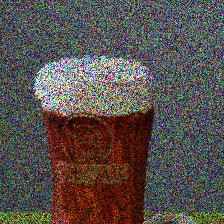

In [23]:
image_c_path = Path("../../data/imagenet-c/")
perturbations = [p.stem for p in image_c_path.iterdir() if p.is_dir()]
severity = 5
pert_idx = 0
class_idx = 0
image_idx = 0
print(perturbations[pert_idx])
image_path = list(
    list((image_c_path / perturbations[pert_idx] / str(severity)).iterdir())[
        class_idx
    ].iterdir()
)[image_idx]
Image.open(image_path)

In [24]:
image_orig_paths = list(Path("../../data/imagenet-val-set/").iterdir())

In [25]:
import torchvision
from torchvision.transforms import CenterCrop

crop = CenterCrop(350)

orig_image = np.array(
    crop(
        Image.open(
            image_orig_paths[0].parent
            / f"{image_path.stem}_{image_path.parent.stem}.JPEG"
        )
    )
)
image_dict = {"original": orig_image}

for pert in perturbations:
    image_dict[pert] = np.array(
        Image.open(
            list(
                list((image_c_path / pert / str(severity)).iterdir())[
                    class_idx
                ].iterdir()
            )[image_idx]
        )
    )

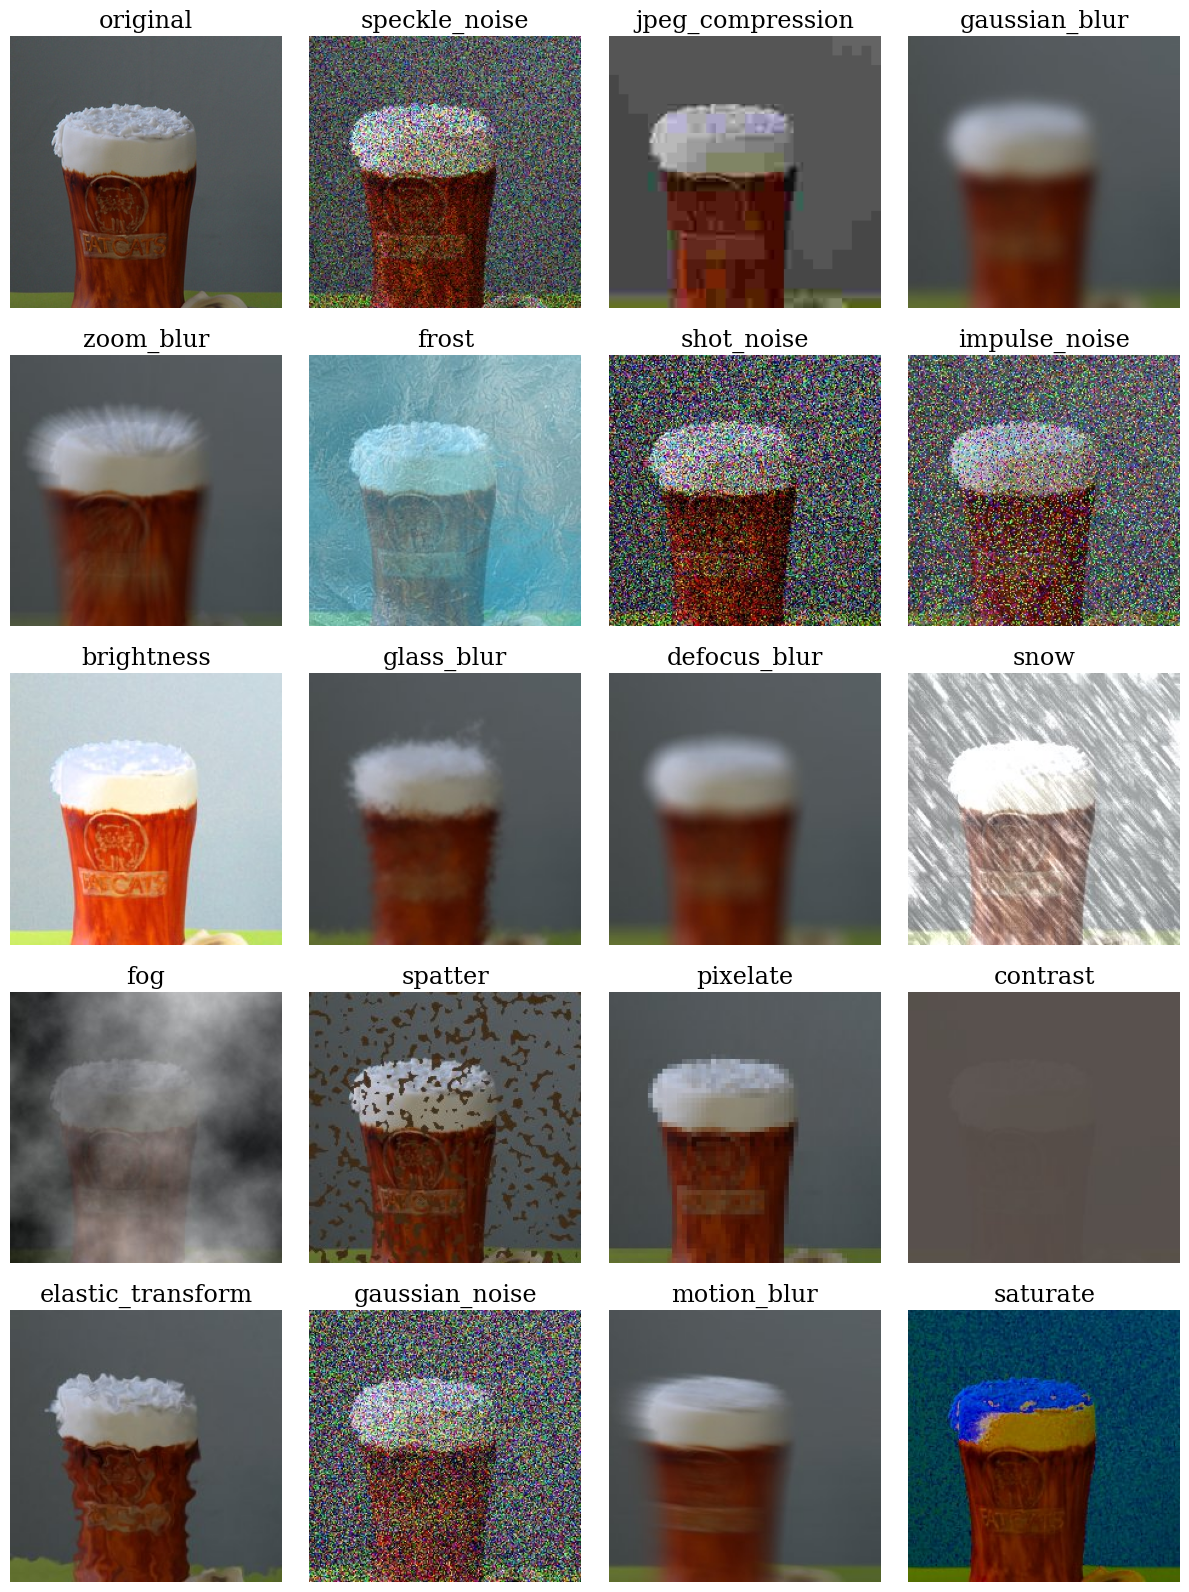

In [27]:
j = 24
sev = 5

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 16))
for (k, v), ax in zip(image_dict.items(), axes.flat):
    ax.imshow(v)
    ax.axis("off")
    ax.set_title(k, fontsize="xx-large")

fig.tight_layout(h_pad=2, w_pad=2)
# plt.savefig(figures_dir / "imagenet_c_images.png", bbox_inches="tight")

In [29]:
num_trials = 10
num_buy = 100
clean = torch.load(saved_embedding_path / "clip_embedding_imagenet_original.pt")

num_sell = 10000

noise_results = {}
for p in tqdm(perturbations):
    noise_values = defaultdict(list)
    for j in range(num_trials):
        B = clean["embeddings"]
        _, buy = train_test_split(B, test_size=num_buy, random_state=j)
        for sev in range(1, 6):
            S = torch.load(
                saved_embedding_path / f"clip_embedding_imagenet_c_{p}_{sev}.pt"
            )["embeddings"]
            sell, _ = train_test_split(S, train_size=num_sell, random_state=j)
            noise_values[sev].append(valuation.get_measurements(buy, sell))
    noise_results[p] = noise_values

  0%|          | 0/19 [00:00<?, ?it/s]

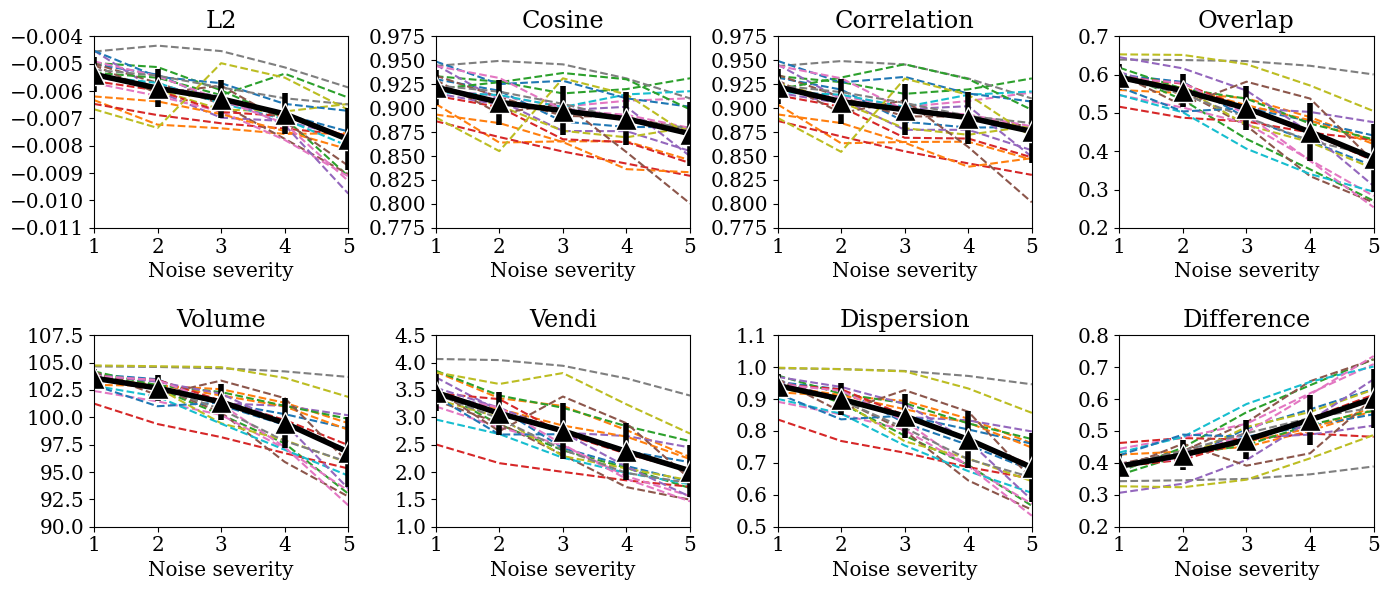

In [80]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))

for ax, val in zip(axes.flat, measures):
    agg = []
    # agg_std  = []
    for _, v in noise_results.items():
        res = []
        for i in range(1, 6):
            values = list(map(itemgetter(val), v[i]))
            res.append(values)
        ax.plot(range(1, 6), np.mean(res, 1), ls="--", marker="")
        agg.append(np.mean(res, 1))
    ax.errorbar(
        range(1, 6),
        np.mean(agg, 0),
        yerr=np.std(agg, 0),
        lw=4,
        ls="-",
        marker="^",
        markersize=16,
        markeredgecolor="w",
        c="k",
    )
    ax.set_xlabel("Noise severity", fontsize="x-large")
    # ax.set_ylabel('Value', fontsize='x-large')
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), fontsize="x-large")
    ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize="x-large")
    ax.set_title(val.capitalize(), fontsize="xx-large")
    ax.set_xlim(1, 5)

fig.tight_layout(w_pad=1, h_pad=2)

# plt.savefig(figures_dir / f"imagenet-noise-compare.eps", bbox_inches="tight")

### Duplications

In [82]:
from sklearn.model_selection import train_test_split

dup_results = {}
num_buy = 100
num_sell = 10000
num_trials = 10
for name in tqdm(datasets.keys()):
    results = defaultdict(list)
    X = datasets[name]["embeddings"]
    print(name, len(X))
    for j in range(num_trials):
        sell, buy = train_test_split(
            X,
            train_size=min(len(X) - num_buy, num_sell),
            test_size=num_buy,
            random_state=j,
        )
        dup1 = sell[: num_sell // 5].repeat(5, 1)
        dup2 = sell[: num_sell // 10].repeat(10, 1)
        dup3 = sell[: num_sell // 25].repeat(25, 1)
        dup4 = sell[: num_sell // 50].repeat(50, 1)
        dup5 = sell[: num_sell // 100].repeat(100, 1)
        dup6 = sell[: num_sell // 200].repeat(200, 1)
        # dup7 = sell[:num_sell//128].repeat(128, 1)
        d0 = valuation.get_measurements(buy, sell)
        d1 = valuation.get_measurements(buy, dup1)
        d2 = valuation.get_measurements(buy, dup2)
        d3 = valuation.get_measurements(buy, dup3)
        d4 = valuation.get_measurements(buy, dup4)
        d5 = valuation.get_measurements(buy, dup5)
        d6 = valuation.get_measurements(buy, dup6)
        # d7 = valuation.get_measurements(buy, dup7)
        results[0].append(d0)
        results[1].append(d1)
        results[2].append(d2)
        results[3].append(d3)
        results[4].append(d4)
        results[5].append(d5)
        results[6].append(d6)
        # results[7].append(d7)
    dup_results[name] = results

  0%|          | 0/20 [00:00<?, ?it/s]

mnist 60000
fashion 60000
emnist 697932
stl10 5000
svhn 73257
cifar 50000
imagenet-val 50000
imagenet-s 50889
imagenet-r 30000
imagenet-a 7500
imagenet-v2 10000
blood 11959
breast 546
chest 78468
derma 7007
path 89996
pneumonia 4708
retina 1080
tissue 165466
organ 34561


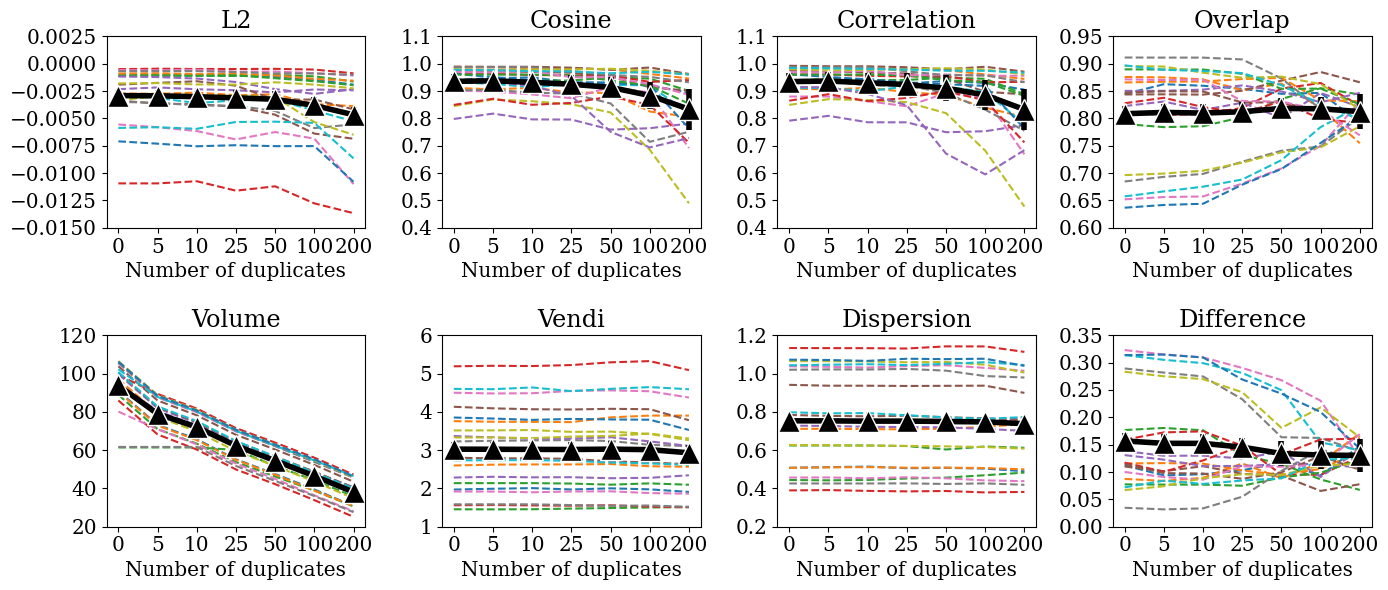

In [85]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))

for ax, val in zip(
    axes.flat,
    measures,
):
    names = list(dup_results.keys())
    agg_mean = []
    agg_std = []
    for k, v in dup_results.items():
        v_mean = [np.mean(list(map(itemgetter(val), v_i))) for v_i in v.values()]
        v_std = [np.std(list(map(itemgetter(val), v_i))) for v_i in v.values()]
        # ax.errorbar(range(5), v_mean, yerr=v_std, ls='--', marker='o')
        ax.plot(v_mean, ls="--", marker="")
        agg_mean.append(v_mean)
        agg_std.append(v_std)
    ax.errorbar(
        range(len(dup_results["mnist"].keys())),
        np.mean(agg_mean, 0),
        yerr=np.mean(agg_std, 0),
        lw=4,
        ls="-",
        marker="^",
        markersize=16,
        markeredgecolor="w",
        c="k",
    )
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), fontsize='x-large')
    # ax.set_xticks(range(8), ['0', '2', '4', '8', '16', '32', '64', '128'], fontsize='x-large')
    ax.set_xticks(
        range(len(dup_results["mnist"].keys())),
        ["0", "5", "10", "25", "50", "100", "200"],
        fontsize="x-large",
    )
    ax.set_xlabel("Number of duplicates", fontsize="x-large")
    # ax.set_ylabel('Value', fontsize='x-large')
    ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), fontsize="x-large")
    ax.set_title(val.capitalize(), fontsize="xx-large")

fig.tight_layout(w_pad=1, h_pad=2)
# plt.savefig(figures_dir / f"duplication.eps", bbox_inches="tight", dpi=800)

# 